# MS-CAM: Multi-Scale Class Activation Maps for Weakly-supervised Segmentation of Geographic Atrophy Lesions in SD-OCT Images
## Demo code

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import os
import os.path
import cv2
import time
from skimage.segmentation import random_walker
import matplotlib.pyplot as plt

%matplotlib inline

import utils
import network
from train_test import prepprocess

In [2]:
batch_size = 2
num_classes = 2
img_num = 128
img_height = 224
img_width = 224
log_dir = './logs/'
gt_dir = './data/test/'
data_ft_dir_root = './data/flatten/'
proj_dir_root = './data/projection/'
scope = 'vgg_16'

### Restoring Subgraph and Generating MS-CAMs

In [3]:
data_test_list = []
label_test_list = []
filenames = [filename for filename in os.listdir(gt_dir) if filename.endswith('.bmp')]
for file in filenames:
    im = cv2.imread(gt_dir + '/' + file, 0)
    for k in range(img_num):
        data_test_list.append(data_ft_dir_root + file.replace('.bmp', '_VBM4D/{}_Flatten.bmp'.format(k + 1)))
        label_test_list.append(int(np.sum(im[:, k]) > 0))
dataset = tf.data.Dataset.from_tensor_slices((data_test_list, label_test_list)).map(prepprocess).batch(batch_size)
itreator = dataset.make_one_shot_iterator()
image_batch, label_batch = itreator.get_next()
x = tf.placeholder(tf.float32,shape=[batch_size, img_height, img_width, 3])
model = network.Model(imgs=x,num_classes=2,scope=scope,img_height=img_height,img_width=img_width,is_training=False)
excitation_list, output = model.build()
# get the activation maps, also use: model.get_cam(excitation_list[0])
cam_0 = model.get_grad_cam_plusplus(output[:,0])
cam_1 = model.get_grad_cam_plusplus(output[:,1])
saver = tf.train.Saver(tf.global_variables())
sess = tf.Session()
ckpt = tf.train.get_checkpoint_state(log_dir)
global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
saver.restore(sess, ckpt.model_checkpoint_path)
# get MS-CAMs corresponding to cube scan
# get negative seeds
cam_cube_0 = []
cam_cube_1 = []
negative_seeds = np.zeros(img_num)
for step in range(img_num//batch_size):
    tes_image = sess.run(image_batch)
    outs_train, classmap_0, classmap_1 = sess.run([output, cam_0, cam_1], feed_dict = {x: tes_image})
    cam_cube_0.append(classmap_0)
    cam_cube_1.append(classmap_1)
    negative_seeds[step*batch_size:step*batch_size+batch_size] = np.argmin(outs_train, axis=1)
sess.close()

INFO:tensorflow:Restoring parameters from ./logs/model.ckpt-2000


### Displaying En-face Images

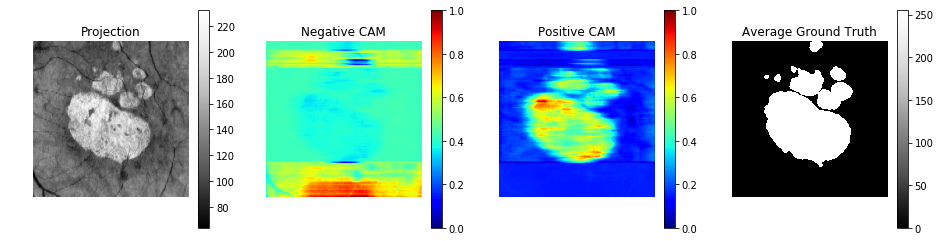

In [4]:
# get en-face MS-CAM
cam_cube_0 = np.concatenate(cam_cube_0, axis=0)
cam_proj_0 = np.sum(cam_cube_0, axis=1)
cam_proj_0 = cv2.resize(cam_proj_0, (512, 512))
cam_cube_1 = np.concatenate(cam_cube_1, axis=0)
cam_proj_1 = np.sum(cam_cube_1, axis=1)
cam_proj_1 = cv2.resize(cam_proj_1, (512, 512))
probs_0 = (cam_proj_0-cam_proj_0.min()) / (cam_proj_0.max()-cam_proj_0.min())
probs_1 = (cam_proj_1-cam_proj_1.min()) / (cam_proj_1.max()-cam_proj_1.min())

cube_name = data_test_list[0].split('/')[-2]
proj_im = cv2.imread(proj_dir_root + cube_name.replace('_VBM4D', '_proj.bmp'), 0)
gt_im = cv2.imread(gt_dir + cube_name.replace('_VBM4D', '.bmp'), 0)

plt.figure(figsize=(16,4))
plt.subplot(141);plt.imshow(proj_im, cmap='Greys_r');plt.title('Projection');plt.axis('off');plt.colorbar();
plt.subplot(142);plt.imshow(probs_0, cmap=plt.cm.jet);plt.title('Negative CAM');plt.axis('off');plt.colorbar();
plt.subplot(143);plt.imshow(probs_1, cmap=plt.cm.jet);plt.title('Positive CAM');plt.axis('off');plt.colorbar();
plt.subplot(144);plt.imshow(gt_im, cmap='Greys_r');plt.title('Average Ground Truth');plt.axis('off');plt.colorbar();

### Weakly Supervised Lesion Segmentation
The en-face MS-CAM is refined by CRF to positive seeds.
Random Walker take negative seeds and positive seeds to segment the final contours.

Text(0.5,1,'Average Ground Truth')

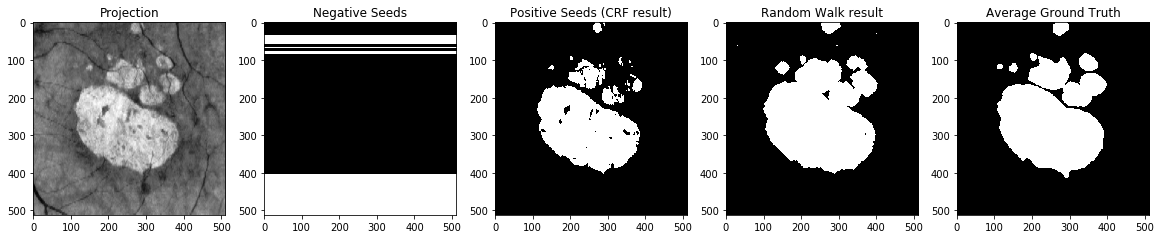

In [5]:
crf_result = utils.dense_crf(np.expand_dims(proj_im,axis = -1), probs_1, probs_0)
negative_seeds = cv2.resize(negative_seeds, (512, 512)).astype(np.uint8)
positive_seeds = np.where(negative_seeds>0, 0, crf_result).astype(np.uint8)
seed_input = negative_seeds + 2 * positive_seeds
rw_im = random_walker(proj_im,seed_input,beta=1.e+6,mode='cg_mg')

plt.figure(figsize=(20,4))
plt.subplot(151);plt.imshow(proj_im, cmap='Greys_r');plt.title('Projection')
plt.subplot(152);plt.imshow(negative_seeds, cmap='Greys_r');plt.title('Negative Seeds')
plt.subplot(153);plt.imshow(positive_seeds, cmap='Greys_r');plt.title('Positive Seeds (CRF result)')
plt.subplot(154);plt.imshow(rw_im, cmap='Greys_r');plt.title('Random Walk result')
plt.subplot(155);plt.imshow(gt_im, cmap='Greys_r');plt.title('Average Ground Truth')